In [31]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
from sklearn.externals import joblib
%matplotlib inline

# camera calibration

In [23]:
cal_list = sorted(glob.glob('./camera_cal/*.jpg'))
objpoints = []
imgpoints = []
objp = np.zeros((6*9, 3), np.float32)
objp[: ,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [32]:
for file in cal_list:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(img, (9, 6), None)
    if ret is True:
        objpoints.append(objp)
        imgpoints.append(corners)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)
joblib.dump(mtx, './mtx.pkl')
joblib.dump(dist, './dist.pkl')

['./dist.pkl']

In [33]:
mtx = joblib.load('./mtx.pkl')
dist = joblib.load('./dist.pkl')

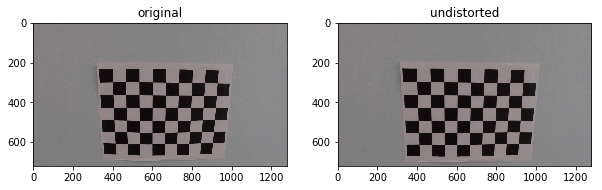

In [34]:
# try out
img = cv2.imread(cal_list[8])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(img)
ax1.set_title('original')
dst = cv2.undistort(img, mtx, dist, None, mtx)
ax2.set_title('undistorted')
ax2.imshow(dst)

# Perspective transform

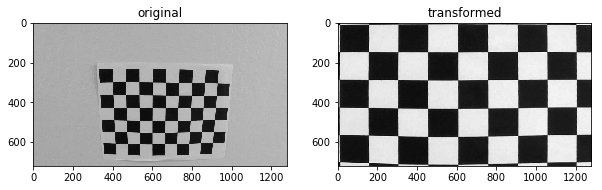

In [42]:
img = cv2.imread(cal_list[8])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(img, (9, 6), None)
src = np.float32([corners[0], corners[8], corners[-9], corners[-1]])
dst = np.float32([[10, 10], [1200, 10],
                 [10, 700],  [1200, 700]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, M, dsize=img.shape[::-1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(img, 'gray')
ax1.set_title('original')
dst = cv2.undistort(img, mtx, dist, None, mtx)
ax2.set_title('transformed')
plt.imshow(warped, 'gray')

## Getting bird view

In [46]:
img_list = sorted(glob.glob('./test_images/*.jpg'))

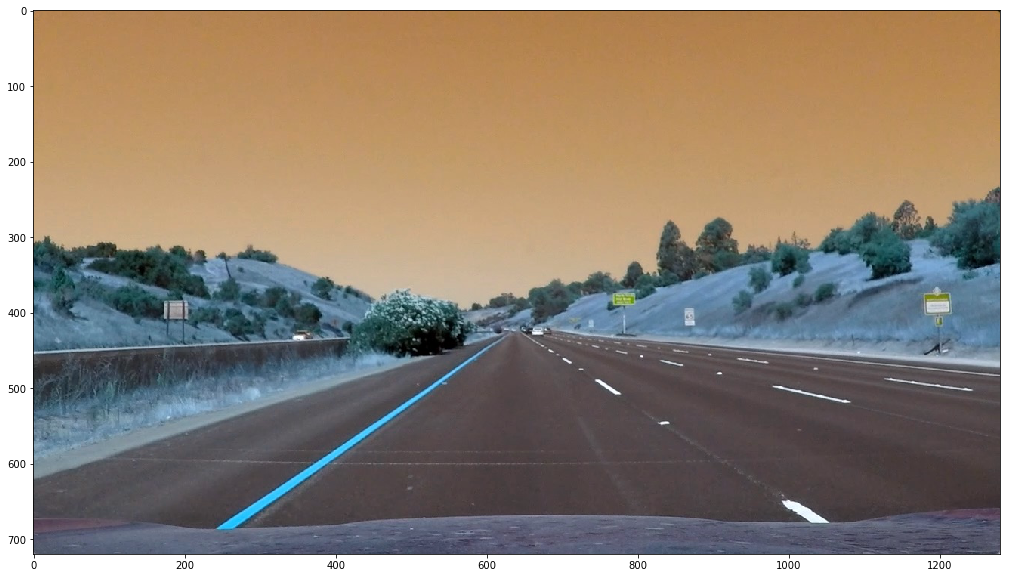

In [49]:
img = cv2.imread(img_list[0])
fig = plt.figure(figsize=(20,10))
plt.imshow(img)

In [52]:
# undistort
mtx = joblib.load('./mtx.pkl')
dist = joblib.load('./dist.pkl')
img = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./img.jpg', img)

True

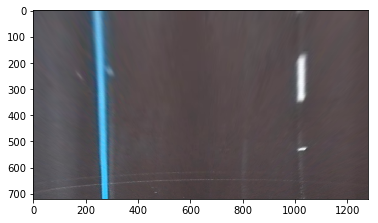

In [55]:
img = cv2.imread('./img.jpg')
# transform
src = np.float32([[588, 477],[699,477],[896,675],[384,675]])
dst = np.float32([[384, 0], [896, 0], [896, 720], [384, 720]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, M, dsize=img.shape[1::-1])

plt.imshow(warped)

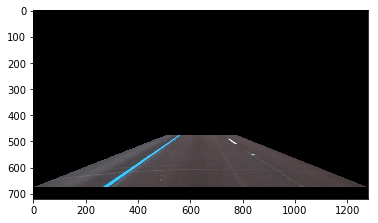

In [56]:
Minv = np.linalg.inv(M)
warpedback = cv2.warpPerspective(warped, Minv, dsize=warped.shape[1::-1])
plt.imshow(warpedback)

# Let's hack warped image

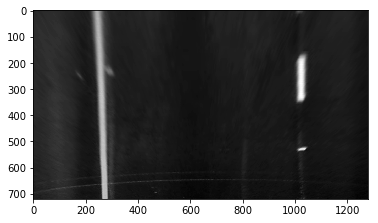

In [58]:
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, 'gray')

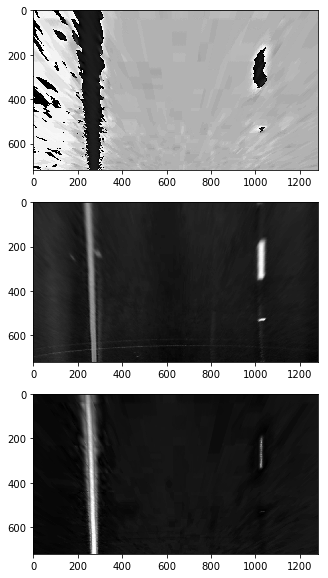

In [62]:
hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
figure, ax = plt.subplots(3,1, figsize=(30, 10))
for i in range(3):
    ax[i].imshow(hls[..., i], 'gray')

In [63]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    scale_factor = np.max(sobel) / 255
    sobel = (np.abs(sobel) / scale_factor).astype(np.uint8)
    grad_binary = np.zeros_like(sobel)
    grad_binary[(sobel > thresh[0]) & (sobel < thresh[1])] = 1    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dsobel = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(dsobel) / 255
    dsobel = (dsobel / scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(dsobel)
    mag_binary[(dsobel > thresh[0]) & (dsobel < thresh[1])] = 1    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dsobel = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(dsobel)
    dir_binary[(dsobel > thresh[0]) & (dsobel < thresh[1])] = 1    
    return dir_binary

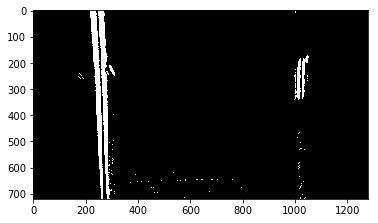

In [120]:
sobel = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(20, 255))
combined = np.zeros_like(sobel)
combined[(sobel == 1) & (hls[..., 2] >= 10)] = 1
plt.imshow(combined, 'gray')

# do histogram thing

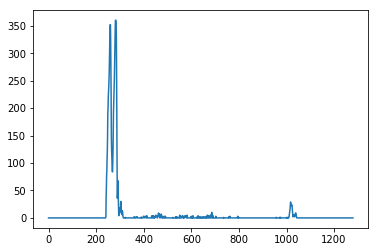

In [121]:
img = combined
histogram = np.sum(img[img.shape[0]//2:, ...], axis=0)
plt.plot(histogram)

In [123]:
binary_warped = img
out_img = np.dstack((img, img, img)) * 255

# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


(720, 0)

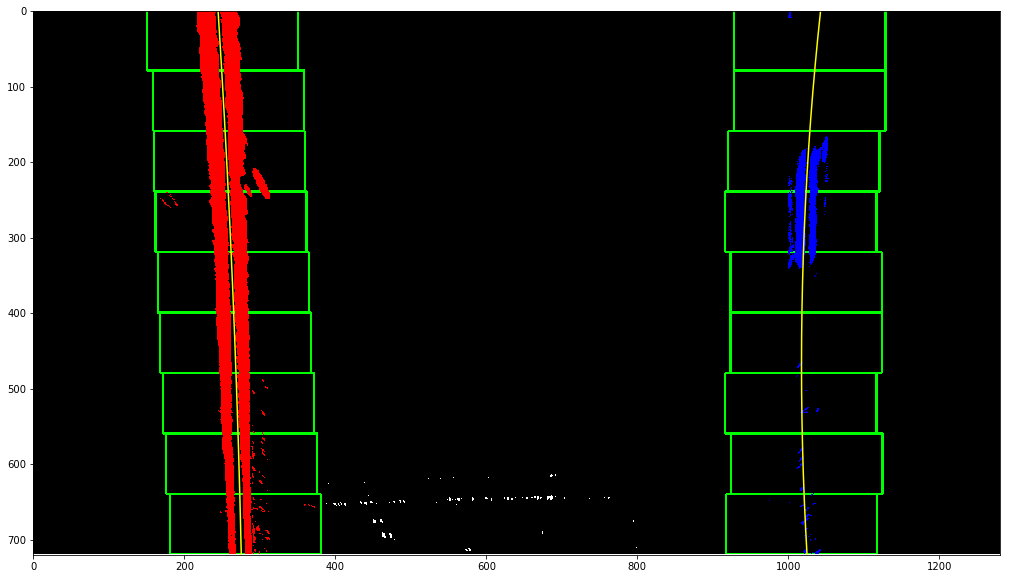

In [125]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
fig = plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

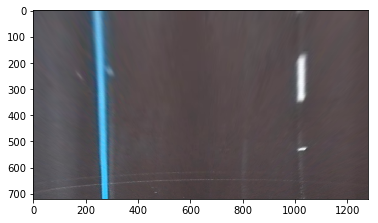

In [127]:
plt.imshow(warped)

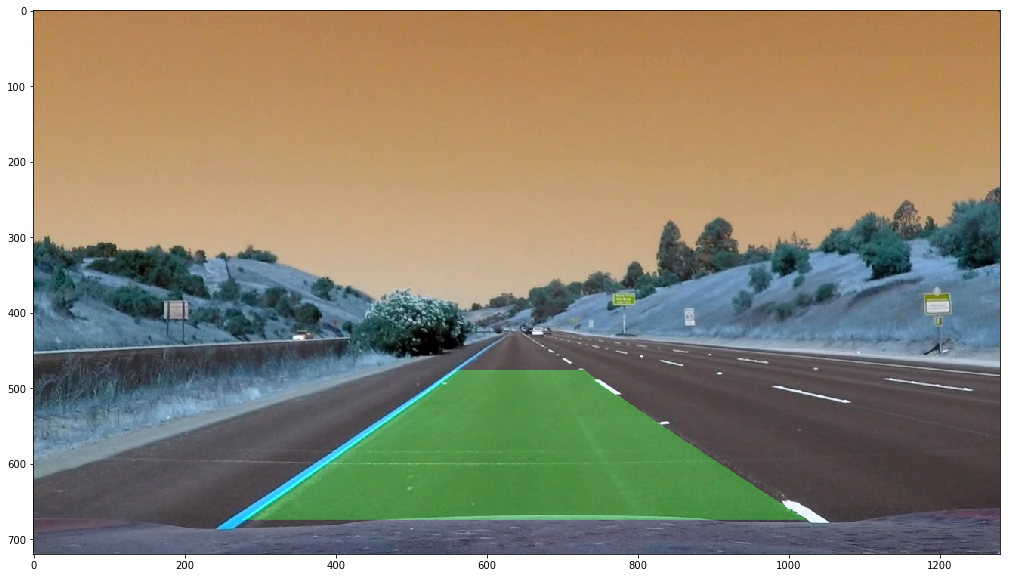

In [132]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped[..., 0]).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(cv2.imread(img_list[0]), 1, newwarp, 0.3, 0)
fig = plt.figure(figsize=(20,10))
plt.imshow(result)